In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
import pickle as pk
import numpy as np
import os
import pandas as pd
current_palette = sns.color_palette()
from copy import deepcopy

# from phys.plot_scripts import generic_plot_utils as rr_gpu
# from phys.phys_utils import nnan_pearsonr as nnan_pearsonr
# from phys import data_utils, phys_utils
# from phys.decode_utils import Decoder_3Ddata
from utils import generic_plot_utils as rr_gpu
from utils.phys_utils import nnan_pearsonr as nnan_pearsonr
from utils import data_utils, phys_utils
from utils.decode_utils import Decoder_3Ddata


In [3]:
def r_t(x_ixcxt_, y_ixcxt_, t_select):
    x_ixcxt, y_ixcxt = x_ixcxt_[:, t_select, :], y_ixcxt_[:, t_select, :]
    niter, ntime = x_ixcxt.shape[0], x_ixcxt.shape[2]
    r_all = []
    for i in range(niter):
        x_cxt, y_cxt = x_ixcxt[i], y_ixcxt[i]
        r_all.append([nnan_pearsonr(x_cxt[:, t_i], y_cxt[:, t_i])[0] for t_i in range(ntime)])
    return np.array(r_all)

def mae_t(x_ixcxt_, y_ixcxt_, t_select):
    x_ixcxt, y_ixcxt = x_ixcxt_[:, t_select, :], y_ixcxt_[:, t_select, :]
    niter, ntime = x_ixcxt.shape[0], x_ixcxt.shape[2]
    mae_all = []
    for i in range(niter):
        x_cxt, y_cxt = x_ixcxt[i], y_ixcxt[i]
        mae_all.append(np.nanmean(np.abs(x_cxt - y_cxt), axis=0))
    return np.array(mae_all)

def get_decoding_metrics(res, t_select_fn='all', t_sel=None):
    yp, yt = res['yp'], res['yt']
    metrics = {'yp': yp, 'yt': yt}
    if t_sel is None:
        t_sel =np.array([True]*yp.shape[1])

    yp_curr = np.array([phys_utils.realign_masked_data(x, align_to_start=True) for x in yp])
    yt_curr = np.array([phys_utils.realign_masked_data(x, align_to_start=True) for x in yt])

    metrics['r_start%d_%s' % (1, t_select_fn)] = r_t(yp_curr, yt_curr, t_sel)
    metrics['mae_start%d_%s' % (1, t_select_fn)] = mae_t(yp_curr, yt_curr, t_sel)

    return metrics

def residual_after_regression(x_, y_):
    t = np.isfinite(x_) & np.isfinite(y_)
    x, y = x_[t], y_[t]
    from sklearn.linear_model import LinearRegression
    if x.ndim == 1:
        x = np.expand_dims(x, axis=1)
    reg = LinearRegression().fit(x, y)
    y_pred = reg.predict(x)
    y_pred_orig = np.ones(y_.shape)* np.nan
    y_pred_orig[t] = y - y_pred
    return y_pred_orig

def fix_axes_for_r_mae(axes):
    axes[0].set_ylim([-0.2, 1.1])
    axes[1].set_ylim([2, 6])
    rr_gpu.make_axis_nice(axes[0])
    rr_gpu.make_axis_nice(axes[1])
    plt.tight_layout()
    return

In [4]:
cmap = plt.get_cmap('Dark2', 8)
figoutpath_base = './' # /Users/hansem/Dropbox (MIT)/MPong/figs/mpong_phys/paper_scratch_202202/' # '/om/user/rishir/figs/mpong_phys/paper_scratch_202202/'
col_ball_pos = cmap(0)

neur_time_axis = [i*50 for i in range(100)]
neur_time_window = (np.array(neur_time_axis)>=200) & (np.array(neur_time_axis)<=400)
neur_baseline_time_window = np.array(neur_time_axis)<400


In [5]:
def get_shuffled_control(res_curr):
    def shuffle_along_axis(a, axis):
        idx = np.random.rand(*a.shape).argsort(axis=axis)
        return np.take_along_axis(a,idx,axis=axis)

    res_shuf = deepcopy(res_curr)
    yp = np.array(res_shuf['all_metrics']['neural_data']['yp'])
    res_shuf['all_metrics']['neural_data']['yp'] = shuffle_along_axis(yp, 1)

    metrics_shuf = get_decoding_metrics(res_shuf['all_metrics']['neural_data'])
    res_shuf['all_metrics']['neural_data'] = metrics_shuf
    return res_shuf

def load_all_data(subject_id,beh_to_decode = 'ball_final_y', timebinsize=50, neural_data_to_use='neural_responses_reliable'):
    # beh_to_decode = 'ball_occ_start_y'  ##### ball_occ_start_y     ball_final_y

    figoutpath = '%s/%s%d/%s/offline_decode/%s/' % (figoutpath_base, subject_id, timebinsize,
                                          neural_data_to_use,beh_to_decode)
    if not os.path.exists(figoutpath):
        os.makedirs(figoutpath)

    dirfn = './data/'
    # dirfn = '/Users/hansem/Dropbox (MIT)/MPong/phys/results/offline_decode_results/%s' % (beh_to_decode)

    fn_spec = 'offline_%s_%s_%d.pkl'
    # fn_spec = 'offline_%s_%s_%d_occ.pkl' ##$
    res = {}
    for fk in [subject_id, 'rnn']:
        fn_tag = fn_spec % (fk, neural_data_to_use, timebinsize)
        fn = '%s/%s' % (dirfn, fn_tag)
        res[fk] = pk.load(open(fn, 'rb'))
    
    res['shuf'] = get_shuffled_control(res[subject_id])
    
    
    res_rnn = res['rnn']
    rnn_time_axis = [i*41.6 for i in range(90)]
    rnn_time_window = (np.array(rnn_time_axis)>=200) & (np.array(rnn_time_axis)<=400)
    all_model_fns = list(res_rnn['all_metrics'])
    palette_reordered = [current_palette[1], current_palette[3],
                     current_palette[2],current_palette[0]]
    lw_panels = ['sim-mov', 'vis-sim-mov', 'vis-mov', 'mov', ]
    df = res_rnn['df']
    lw_all = np.array(df['loss_weight_type'])
    rnn_specs = {
        'lw_all':lw_all,'lw_panels':lw_panels,
        'palette_reordered':palette_reordered,'all_model_fns':all_model_fns,
        'rnn_time_window':rnn_time_window, 'rnn_time_axis':rnn_time_axis,
    }
    
    
    return res, figoutpath, rnn_specs


In [6]:
subject_id = 'all_hand_dmfc' # 'random' # 'all_hand_dmfc'
beh_to_decode = 'ball_occ_start_y'  ##### ball_occ_start_y     ball_final_y
res_occ, figoutpath, rnn_specs = load_all_data(subject_id,beh_to_decode)

beh_to_decode = 'ball_final_y'  ##### ball_occ_start_y     ball_final_y
res, figoutpath, rnn_specs = load_all_data(subject_id,beh_to_decode)


In [7]:
meta_dfn = './data/valid_meta_sample_full.pkl'
# meta_dfn = '/Users/hansem/Dropbox (MIT)/MPong/lib/MentalPong/pong_basic/RF/occluded_pong_bounce1_pad8_4speed/valid_meta_sample_full.pkl'
# meta_dfn = '/om/user/rishir/data/pong_basic/RF/occluded_pong_bounce1_pad8_4speed/valid_meta_sample_full.pkl'
meta = pd.read_pickle(meta_dfn)

# subsample phys conditions
unique_conds = phys_utils.PONG_BASIC_META_IDX
py_meta_index = np.array(meta['meta_index'])
ordered_condition_index = [np.nonzero(py_meta_index == uci)[0][0] for uci in unique_conds]
meta_subsampled = meta.iloc[ordered_condition_index]
meta_subsampled = meta_subsampled.reset_index(drop=True)

In [8]:
idx_no_bounce = np.nonzero(np.array(meta_subsampled['n_bounce_correct']) == 0)
idx_bounce = np.nonzero(np.array(meta_subsampled['n_bounce_correct']) > 0)

idx_no_bounce = idx_no_bounce[0]
idx_bounce = idx_bounce[0]

In [9]:
# correlate with behavior
def err_func(x,y, err_type='abs_residual'):
    if err_type == 'abs_residual':
        return np.abs(residual_after_regression(x,y))
    elif err_type == 'residual':
        return residual_after_regression(x,y)
    elif err_type == 'abs_diff':
        return np.abs(x-y)
    elif err_type == 'diff':
        return (x-y)
    elif err_type == 'y':
        return y
    elif err_type == 'x':
        return x
    else:
        return y

def get_behavior(subject_id):
    dset = data_utils.load_neural_dataset(subject_id=subject_id)
    paddle_y = np.array(dset['behavioral_responses']['occ']['paddle_pos_y'])
    ball_y = np.array(dset['behavioral_responses']['occ']['ball_pos_y'])
    mask_f = np.array(dset['masks']['occ']['f_pad0'])
    paddle_y_m = phys_utils.apply_mask(paddle_y, mask_f)
    ball_y_m = phys_utils.apply_mask(ball_y, mask_f)
    x_b, y_b = np.nanmean(ball_y_m, axis=1), np.nanmean(paddle_y_m, axis=1)
    return x_b, y_b

#  neural prediction
def get_neural_prediction_endpoint_err(subject_id, fk='neural_data',
                                      max_t=20, niter=100, subject_id_beh=None,
                                       err_type='residual', t_subsampled=None,id_bounce=2):
    # id_bounce = 0 (no_bounce), 1 (bounce), 2 (all)

    if subject_id_beh is None:
        subject_id_beh = subject_id
    x_b, y_b = get_behavior(subject_id_beh)
    if id_bounce == 0: # no bounce
        x_b, y_b = x_b[idx_no_bounce], y_b[idx_no_bounce]
    elif id_bounce == 1: # bounce
        x_b, y_b = x_b[idx_bounce], y_b[idx_bounce]
    elif id_bounce == 2: # all
        x_b, y_b = x_b, y_b

    err_b = err_func(x_b,y_b, err_type=err_type)

    yp = np.array(res[subject_id]['all_metrics'][fk]['yp'])
    yt = np.array(res[subject_id]['all_metrics'][fk]['yt'])

    rho = []
    pvalue = []
    for t_i in range(max_t):
        rho_curr = []
        pvalue_curr = []
        for i in range(niter):
            if id_bounce == 0: # no bounce
                x_n, y_n = yt[i,idx_no_bounce,t_i], yp[i,idx_no_bounce,t_i]
            elif id_bounce == 1: # bounce
                x_n, y_n = yt[i,idx_bounce,t_i], yp[i,idx_bounce,t_i]
            elif id_bounce == 2: # all
                x_n, y_n = yt[i,:,t_i], yp[i,:,t_i]
            err_n = err_func(x_n,y_n, err_type=err_type)
            r,p = nnan_pearsonr(err_n, err_b)
            rho_curr.append(r)
            pvalue_curr.append(p)
        rho.append(rho_curr)
        pvalue.append(pvalue_curr)
    return { 'rho_with_err': np.array(rho),
             'pvalue': np.array(pvalue),
            'yt': yt, 'yp': yp, 'err_b':err_b, 'err_type': err_type}

#  neural prediction
def get_neural_prediction_endpoint_err_occ(subject_id, fk='neural_data',
                                      max_t=20, niter=100, subject_id_beh=None,
                                       err_type='residual', t_subsampled=None):
    if subject_id_beh is None:
        subject_id_beh = subject_id
    x_b, y_b = get_behavior(subject_id_beh)
    yp = np.array(res_occ[subject_id]['all_metrics'][fk]['yp'])
    yt = np.array(res_occ[subject_id]['all_metrics'][fk]['yt'])

    err_b = err_func(x_b,y_b, err_type=err_type)
    rho = []
    pvalue = []
    for t_i in range(max_t):
        rho_curr = []
        pvalue_curr = []
        for i in range(niter):
            x_n, y_n = yt[i,:,t_i], yp[i,:,t_i]
            err_n = err_func(x_n,y_n, err_type=err_type)
            r,p = nnan_pearsonr(err_n, err_b)
            rho_curr.append(r)
            pvalue_curr.append(p)
        rho.append(rho_curr)
        pvalue.append(pvalue_curr)
    return { 'rho_with_err': np.array(rho),
             'pvalue': np.array(pvalue),
            'yt': yt, 'yp': yp, 'err_b':err_b, 'err_type': err_type}


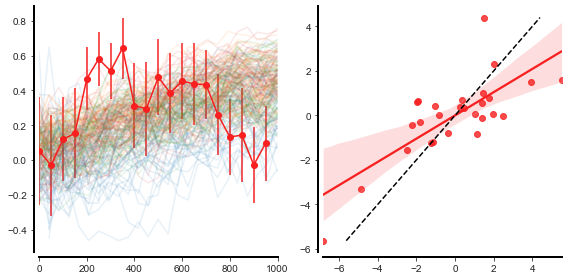

In [10]:
f,axes = plt.subplots(1,2,figsize=(8,4))
max_t, max_t_rnn = 20, 25

x_all=[[],[],[],[]]

for mi, mfk in enumerate(rnn_specs['all_model_fns']):
    res_static_rnn = get_neural_prediction_endpoint_err('rnn',fk=mfk,
                                                        subject_id_beh=subject_id, max_t=max_t_rnn, id_bounce=1)
    x = np.nanmean(res_static_rnn['rho_with_err'], axis=1)
    loss_idx = rnn_specs['lw_panels'].index(rnn_specs['lw_all'][mi])
    col = rnn_specs['palette_reordered'][loss_idx]
    axes[0].plot(rnn_specs['rnn_time_axis'][:max_t_rnn], x, color=col, alpha=0.1)

    x_all[loss_idx].append(x)

for loss_idx in range(len(x_all)):
    np.savetxt('bounce_r_beh_loss%s.csv'%(loss_idx),x_all[loss_idx], fmt='%5.3f', delimiter=',', newline='\n')

res_static_dmfc = get_neural_prediction_endpoint_err('all_hand_dmfc',fk='neural_data', max_t=max_t, id_bounce=1)
res_static_ = res_static_dmfc
rho_with_err = res_static_['rho_with_err']
yt, yp = res_static_['yt'], res_static_['yp']
err_b = res_static_['err_b']
err_type = res_static_['err_type']

axes[0].errorbar(neur_time_axis[:max_t], np.nanmean(rho_with_err, axis=1),
                yerr=np.nanstd(rho_with_err, axis=1), fmt='-o', color=[0.97, 0.12, 0.12])
np.savetxt('bounce_r_beh_neural.csv',np.nanmean(rho_with_err, axis=1), fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('bounce_r_beh_neural_std.csv',np.nanstd(rho_with_err, axis=1), fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('bounce_t_beh_neural.csv',neur_time_axis[:max_t], fmt='%5.3f', delimiter=',', newline='\n')
axes[0].set_xlim([0,1000])
rr_gpu.make_axis_nice(axes[0])

t_i = [np.argmax(np.nanmean(rho_with_err, axis=1))]
x_n, y_n  = np.nanmean(yt[:,idx_bounce,t_i], axis=(0)), np.nanmean(yp[:,idx_bounce,t_i], axis=(0))
err_n = err_func(x_n,y_n, err_type=err_type)

sns.regplot(x=err_n, y=err_b,  ax=axes[1], color=[0.97, 0.12, 0.12])
np.savetxt('bounce_err_n_beh_neural.csv',[err_n], fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('bounce_err_b_beh_neural.csv',[err_b], fmt='%5.3f', delimiter=',', newline='\n')
axes[1].plot(np.unique(err_b), np.unique(err_b), 'k--')
rr_gpu.make_axis_nice(axes[1])

plt.tight_layout()
# f.savefig('%s/correlation_with_behavior_occ.pdf' % figoutpath)
##$
f.savefig('%s/correlation_with_behavior_bounce.pdf' % figoutpath)





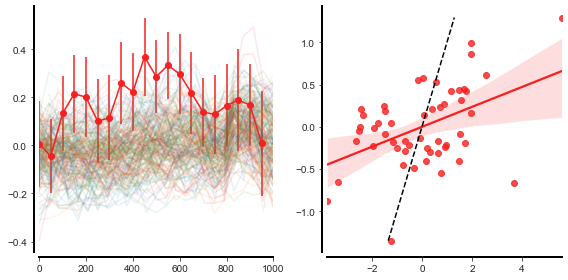

In [11]:
f,axes = plt.subplots(1,2,figsize=(8,4))
max_t, max_t_rnn = 20, 25

x_all=[[],[],[],[]]

for mi, mfk in enumerate(rnn_specs['all_model_fns']):
    res_static_rnn = get_neural_prediction_endpoint_err('rnn',fk=mfk,
                                                        subject_id_beh=subject_id, max_t=max_t_rnn, id_bounce=0)
    x = np.nanmean(res_static_rnn['rho_with_err'], axis=1)
    loss_idx = rnn_specs['lw_panels'].index(rnn_specs['lw_all'][mi])
    col = rnn_specs['palette_reordered'][loss_idx]
    axes[0].plot(rnn_specs['rnn_time_axis'][:max_t_rnn], x, color=col, alpha=0.1)

    x_all[loss_idx].append(x)

for loss_idx in range(len(x_all)):
    np.savetxt('no_bounce_r_beh_loss%s.csv'%(loss_idx),x_all[loss_idx], fmt='%5.3f', delimiter=',', newline='\n')

res_static_dmfc = get_neural_prediction_endpoint_err('all_hand_dmfc',fk='neural_data', max_t=max_t, id_bounce=0)
res_static_ = res_static_dmfc
rho_with_err = res_static_['rho_with_err']
yt, yp = res_static_['yt'], res_static_['yp']
err_b = res_static_['err_b']
err_type = res_static_['err_type']

axes[0].errorbar(neur_time_axis[:max_t], np.nanmean(rho_with_err, axis=1),
                yerr=np.nanstd(rho_with_err, axis=1), fmt='-o', color=[0.97, 0.12, 0.12])
np.savetxt('no_bounce_r_beh_neural.csv',np.nanmean(rho_with_err, axis=1), fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('no_bounce_r_beh_neural_std.csv',np.nanstd(rho_with_err, axis=1), fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('no_bounce_t_beh_neural.csv',neur_time_axis[:max_t], fmt='%5.3f', delimiter=',', newline='\n')
axes[0].set_xlim([0,1000])
rr_gpu.make_axis_nice(axes[0])

t_i = [np.argmax(np.nanmean(rho_with_err, axis=1))]
x_n, y_n  = np.nanmean(yt[:,idx_no_bounce,t_i], axis=(0)), np.nanmean(yp[:,idx_no_bounce,t_i], axis=(0))
err_n = err_func(x_n,y_n, err_type=err_type)

sns.regplot(x=err_n, y=err_b,  ax=axes[1], color=[0.97, 0.12, 0.12])
np.savetxt('no_bounce_err_n_beh_neural.csv',[err_n], fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('no_bounce_err_b_beh_neural.csv',[err_b], fmt='%5.3f', delimiter=',', newline='\n')
axes[1].plot(np.unique(err_b), np.unique(err_b), 'k--')
rr_gpu.make_axis_nice(axes[1])

plt.tight_layout()
# f.savefig('%s/correlation_with_behavior_occ.pdf' % figoutpath)
##$
f.savefig('%s/correlation_with_behavior_no_bounce.pdf' % figoutpath)